## What to expect as an Airbnb Host in Berlin

Airbnb has successfully disrupted the traditional hospitality industry as more and more travelers decide to use Airbnb as their primary accommodation provider. Since its inception in 2008, Airbnb has seen an enormous growth, with the number of rentals listed on its website growing exponentially each year.

In Germany, no city is more popular than Berlin. That implies that Berlin is one of the hottest markets for Airbnb in Europe, with over 22,552 listings as of November 2018. With a size of 891 km², this means there are roughly 25 homes being rented out per km² in Berlin on Airbnb!

Considering the possibility that I might have to relocate for a new data science job, but want to keep my current flat in Berlin (which is quite cheap!), I might wonder if it could be worth it to offer my jewel on Airbnb. Could this perhaps be a profitable option? However, it is difficult for potential hosts to know what the true value of their home is, and how in-demand their home might be. And since location and furniture are obviously fixed for the most part, is there anything else a host can influence - such as description, communication patterns, and/or additional services to boost their earnings?

The following three questions will drive this project:

> **1. Can we determine a fairly spot-on daily price for a new accommodation that fits into its specific market environment and competitors in Berlin?** <br>
> **2. How big is the demand likely to be? What can a host expect with respect to occupancy and earnings here in Berlin? What factors influence how in-demand it is?** <br>
> **3. And lastly: What do visitors like and dislike?**

The first question focuses on the accommodation features and decisions a new host can make with regards to initial presentation, i.e. posting a picture of him- or herself on the website, determining a minimum length of stay, offering instant bookings etc. A machine learning algorithm will be applied to try to get an answer. 
<br> The second question is similar and even stronger. It focuses on geography to explain the demand, but will mainly use visualizations to narrow down the search for answers. 
<br> The last question processes the reviews to find out what peoples' likes and dislikes are. Natural Language Processing (NLP) and specifically Sentiment Analysis are what we will use here.

To not prevent my notebook(s) from ever being read due to their length, I wrote one "paper" - aka notebook - for each question. The first notebook can be found here (**Insert Link!!!!**) and the third one here (**Insert Link!!!!**).

### The datasets

In the second notebook, I will combine the summary listings and the detailed Berlin listings data, sourced from the Inside Airbnb website. The goal is to visualize the rental landscape and try to understand the aspects influencing the demand. Both datasets were scraped on November 07th 2018.

## > No. 2 _ Explaining the Demand & Expected Earnings
<a id='Table of contents'></a>

### <a href='#1. Obtaining and Viewing the Data'> 1. Obtaining and Viewing the Data </a>

### <a href='#2. Preprocessing the Data'> 2. Preprocessing the Data </a>
* <a href='#2.1. Engineer Reviews per Month'> 2.1. Engineer Reviews per Month </a>
* <a href='#2.2. Combining Datasets'> 2.2. Combining Datasets </a>
* <a href='#2.3. Cleaning the Price Columns'> 2.3. Cleaning the Price Columns </a>
* <a href='#2.4. Occupancy Estimate'> 2.4. Occupancy Estimate </a>
* <a href='#2.5. Income Estimate'> 2.5. Income Estimate </a>

### <a href='#3. Exploratory Data Analysis (EDA)'> 3. Exploratory Data Analysis (EDA) </a>
* <a href='#3.1. Getting Started with a Heat Map'> 3.1. Getting Started with a Heat Map </a>
* <a href='#3.2. Seasonal Demand'> 3.2. Seasonal Demand </a>
* <a href='#3.3. Demand by Status SUPERHOST'> 3.3. Demand by Status SUPERHOST </a>
* <a href='#3.4. Demand by Neighbourhood'> 3.4. Demand by Neighbourhood </a>
* <a href='#3.5. Demand by Capacity'> 3.5. Demand by Capacity </a>

* <a href='#3.6. Demand by Price'> 3.6. Demand by Price </a>

### <a href='#4. Interpreting the Data'> 4. Interpreting the Data </a>

### <a href='#5. Appendix'> 5. Appendix </a>

### 1. Obtaining and Viewing the Data 
<a id='1. Obtaining and Viewing the Data'></a>

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
plt.style.use('seaborn')
import seaborn as sns
import folium

import warnings
warnings.filterwarnings("ignore")

In [2]:
df_raw = pd.read_csv('data/insideAirbnb/reviews.csv.gz')
df_raw.head(2)

,listing_id,id,date,reviewer_id,reviewer_name,comments
0,2015,69544350,2016-04-11,7178145,Rahel,Mein Freund und ich hatten gute gemütliche vie...
1,2015,69990732,2016-04-15,41944715,Hannah,Jan was very friendly and welcoming host! The ...


In [3]:
# drop unnecessary columns
df_raw.drop(['reviewer_id', 'reviewer_name', 'comments'], axis=1, inplace=True)

# rename id column and replace current value simply by 1 to later count the # of reviews per accommodation
df_raw.rename({'id':'review_count'}, axis=1, inplace=True)
df_raw.review_count = 1

# checking shape and duplicates
print("The first dataset has {} rows and {} columns.".format(*df_raw.shape))
print("It contains {} duplicates.".format(df_raw.duplicated().sum()))

df_raw.head(2)

The first dataset has 401963 rows and 3 columns.
It contains 1242 duplicates.


,listing_id,review_count,date
0,2015,1,2016-04-11
1,2015,1,2016-04-15


*Back to: <a href='#Table of contents'> Table of contents</a>*
### 2. Preprocessing the Data 
<a id='2. Preprocessing the Data'></a>

#### 2.1. Engineer Reviews per Month
<a id='2.1. Engineer Reviews per Month'></a>

*1. Process the date column and create a new dataframe*

In [4]:
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 401963 entries, 0 to 401962
Data columns (total 3 columns):
listing_id      401963 non-null int64
review_count    401963 non-null int64
date            401963 non-null object
dtypes: int64(2), object(1)
memory usage: 9.2+ MB


In [5]:
# cast date-column from current object datatype to datetime datatype
df_raw.date = pd.to_datetime(df_raw.date, format="%Y-%m-%d")

Let's take the most recent total 12 months we can get hold of. As the scraping took place on November 07th 2018, we can have a full year starting November 1st 2017 and ending October 31st 2018:

In [6]:
count_2017_18 = df_raw[df_raw["date"].isin(pd.date_range('2017-11-01', '2018-10-31'))]
print("The dataset 2017/2018 has {} reviews and {} columns.".format(*count_2017_18.shape))

The dataset 2017/2018 has 165873 reviews and 3 columns.


In [7]:
# set the date as index and sort by index
count_2017_18 = count_2017_18.set_index('date').sort_index()

*2. Calculate reviews per month*

In [8]:
# group by month and listing_id, i.e. specific apartment 
# agg argument: #work on this col:  {#name the new col : #perform count operation}                        
count_2017_18_monthly = count_2017_18.groupby([pd.TimeGrouper(freq='M'), 'listing_id'])['review_count']\
                                         .agg({'review_count':{'reviews_per_month':'count'}})\
                                         .reset_index()

In [9]:
# initial check
count_2017_18_monthly.head(2)

,date,listing_id,review_count
,,,reviews_per_month
0,2017-11-30,3309,1
1,2017-11-30,7071,2


In [10]:
# to flatten the multi-index, we a) reset the index in the grouby statement above ...
# ... and b) now define column names
count_2017_18_monthly.columns = ['date', 'listing_id', 'reviews_per_month']

# set date as index again
count_2017_18_monthly.set_index('date', inplace=True)

# check again
count_2017_18_monthly.head(2)

,listing_id,reviews_per_month
date,,
2017-11-30,3309,1
2017-11-30,7071,2


In [11]:
#count_2017_18_monthly[count_2017_18_monthly.listing_id==2015]

In [13]:
# get rid of date index
count_2017_18_monthly = count_2017_18_monthly.reset_index()

# group by listing_id and count reviews, turn it into a dataframe without groupby index
count_2017_18_monthly = pd.DataFrame(count_2017_18_monthly.groupby('listing_id')['reviews_per_month'].mean()\
                                                          .reset_index())

count_2017_18_monthly.head()

,listing_id,reviews_per_month
0,2015,2.888889
1,2695,2.000000
2,3309,1.000000
3,7071,3.454545
4,9991,1.000000


*Back to: <a href='#Table of contents'> Table of contents</a>*
#### 2.2. Combining Datasets
<a id='2.2. Combining Datasets'></a>

So far we only have pure countings of reviews per lodging. Let's take a second dataset to enrich our data:

In [14]:
df_2 = pd.read_csv('data/insideAirbnb/listings.csv.gz')
df_2.head(1)

,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,...,requires_license,license,jurisdiction_names,instant_bookable,is_business_travel_ready,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,reviews_per_month
0,2015,https://www.airbnb.com/rooms/2015,20181107122246,2018-11-07,Berlin-Mitte Value! Quiet courtyard/very central,Great location! 30 of 75 sq meters. This wood...,A+++ location! This „Einliegerwohnung“ is an e...,Great location! 30 of 75 sq meters. This wood...,none,It is located in the former East Berlin area o...,...,t,NaN,NaN,f,f,strict_14_with_grace_period,f,f,4,3.76


In [15]:
# merging full 2017/2018 dataframe + add specific columns from df_2
df = pd.merge(count_2017_18_monthly, df_2[['id', 'price', 'cleaning_fee', 'neighbourhood_group_cleansed', 
                          'latitude', 'longitude', 'property_type', 'accommodates', 
                          'bathrooms', 'bedrooms', 'bed_type', 'host_is_superhost']], 
              left_on='listing_id', right_on='id')

# drop 'id' from right dataframe as it's the same as 'listing_id' on the left dataframe
df.drop(['id'], axis=1, inplace=True)

# shorten the name of one column
df.rename({'neighbourhood_group_cleansed':'neighbourhood'}, axis=1, inplace=True)

# check the dataframe
print("The dataset has {} rows and {} columns - after combining it.".format(*df.shape))
print("It contains {} duplicates.".format(df.duplicated().sum()))
df.head(2)

The dataset has 13609 rows and 13 columns - after combining it.
It contains 0 duplicates.


,listing_id,reviews_per_month,price,cleaning_fee,neighbourhood,latitude,longitude,property_type,accommodates,bathrooms,bedrooms,bed_type,host_is_superhost
0,2015,2.888889,$60.00,$30.00,Mitte,52.534537,13.402557,Guesthouse,3,1.0,1.0,Real Bed,t
1,2695,2.000000,$17.00,$0.00,Pankow,52.548513,13.404553,Apartment,2,1.0,1.0,Real Bed,f


*Back to: <a href='#Table of contents'> Table of contents</a>*
#### 2.3. Cleaning the Price Columns
<a id='2.3. Cleaning the Price Columns'></a>

In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13609 entries, 0 to 13608
Data columns (total 13 columns):
listing_id           13609 non-null int64
reviews_per_month    13609 non-null float64
price                13609 non-null object
cleaning_fee         10794 non-null object
neighbourhood        13609 non-null object
latitude             13609 non-null float64
longitude            13609 non-null float64
property_type        13609 non-null object
accommodates         13609 non-null int64
bathrooms            13596 non-null float64
bedrooms             13601 non-null float64
bed_type             13609 non-null object
host_is_superhost    13607 non-null object
dtypes: float64(5), int64(2), object(6)
memory usage: 1.5+ MB


As we can see above, `price` and `cleaning_fee` are both string columns with the latter containing substantial null values which most probably means that these host do not charge any cleaning fee. Let's quickly tidy up here:

In [17]:
# convert price column into numeric value
df.price = df.price.str.replace('$', '').str.replace(',', '').astype(float).astype(int)
df.price.isna().sum()

0

In [18]:
# repleace missing values with zero and convert cleaning_fee column into numeric value
df.cleaning_fee.fillna('$0.00', inplace=True)
df.cleaning_fee = df.cleaning_fee.str.replace('$', '').str.replace(',', '').astype(float).astype(int)
df.cleaning_fee.isna().sum()

0

In [19]:
# investigate price column
df['price'].describe()

count    13609.000000
mean        65.109045
std        158.996457
min          0.000000
25%         33.000000
50%         49.000000
75%         73.000000
max       8600.000000
Name: price, dtype: float64

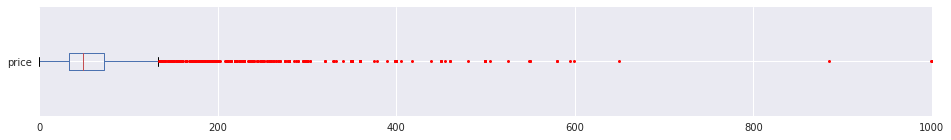

In [20]:
# boxplot of price column
red_square = dict(markerfacecolor='r', markeredgecolor='r', marker='.')
df['price'].plot(kind='box', xlim=(0, 1000), vert=False, flierprops=red_square, figsize=(16,2));

The boxplot above shows quite a skewed distribution with a long tail of high-priced outliers, while 75% of all rentals cost only up to 70 Euro. For this project, let's remove extremely high priced rentals above € 300/night to maintain comparability.

In [21]:
df.drop(df[df['price'] > 300].index, axis=0, inplace=True)
df['price'].describe()

count    13526.000000
mean        59.243457
std         40.413352
min          0.000000
25%         33.000000
50%         49.000000
75%         70.000000
max        300.000000
Name: price, dtype: float64

*Back to: <a href='#Table of contents'> Table of contents</a>*
#### 2.4. Occupancy Estimate
<a id='2.4. Occupancy Estimate'></a>

One of the biggest issues with Airbnb is to get the occupancy rate for each host or for a market. *Inside Airbnb*, the website I sourced the data from, uses an occupancy model which they call the "San Francisco Model" with a methodology as follows:

1. A **Review Rate** of 50% is used to convert reviews to estimated bookings. Other administrative authorities are said to use a review rate of 72% (however this may be attributed to an unreliable source: Airbnb's CEO and co-founder Brian Chesky) - or one of 30.5% (based on comparing public data of reviews to the The New York Attorney General’s report on Airbnb released in October 2014.) *Inside Airbnb* chose 50% as it sits almost exactly between 72% and 30.5%. It basically means that only 50% of all visitors write a review. With that said, the number of reviews per month divided by the review rate equals an estimation of actual visitors.
2. An **average length of stay** for each city is usually published by Airbnb. This number multiplied by the estimated bookings for each listing over a period gives **the occupancy rate**.
3. Finally, the **income** can be calculated by multiplying the occupancy rate with the price and the time period of interest, here 12 months:

>**Monthly Occupancy Rate = Average Length of Stay * (No of reviews per Month / Review Rate)**<br>
*According to the latest update of Airbnb itself, guests who booked via Airbnb in Berlin in 2017, spent 4.2 nights 
on average here.*

>**Yearly Income = Monthly Occupancy Rate * Price * 12 Months**

*Modest Estimate*

With a very modest review rate of 0.5 we assume that only every second guest left a review. I could imagine many more visitors actually write a feedback. But let's calculate this conservative estimate first:

In [22]:
avg_length_of_stay_berlin = 4.2
review_rate_modest = 0.5

# calculate the occupancy and round the result
df['modest_occupancy'] = round(avg_length_of_stay_berlin * (df['reviews_per_month']/review_rate_modest), 2)

# occupancy cannot be greater than 100% - are there any mistakes?
len(df[df['modest_occupancy'] > 100])

4

In [23]:
# let's drop occupancy rates > 100
df.drop(df[(df['modest_occupancy'] > 100)].index, axis=0, inplace=True)

# check the distribution
df['modest_occupancy'].describe()

count    13522.000000
mean        17.885419
std         11.570805
min          8.400000
25%          8.400000
50%         14.000000
75%         22.400000
max         98.700000
Name: modest_occupancy, dtype: float64

*Optimistic Estimate*

Now let's reach out for a more optimistic estimate of occupancy using a review rate of 0.4 which assumes that only 40% of all real actually left a review, so that the number of reviews point to a higher occupancy than in the modest estimate we did before:

In [24]:
review_rate_optimistic = 0.4

# calculate the occupancy and round the result
df['optimistic_occupancy'] = round(avg_length_of_stay_berlin * (df['reviews_per_month']/review_rate_optimistic), 2)

# occupancy cannot be greater than 100% - are there any mistakes?
len(df[df['optimistic_occupancy'] > 100])

13

In [25]:
# let's drop the occupancy rates > 100
df.drop(df[(df['optimistic_occupancy'] > 100)].index, axis=0, inplace=True)

# check the distribution
df['optimistic_occupancy'].describe()

count    13509.000000
mean        22.274628
std         14.224291
min         10.500000
25%         10.500000
50%         17.500000
75%         28.000000
max         99.750000
Name: optimistic_occupancy, dtype: float64

*Comparing Occupancy Estimates*

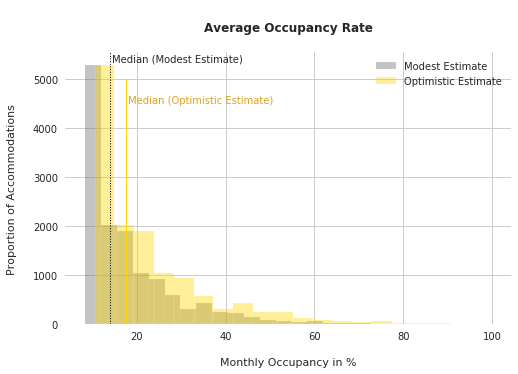

In [28]:
sns.set_style("whitegrid")
plt.figure(figsize=(8,5))

sns.distplot(df['modest_occupancy'], kde=False, bins=20, color='dimgrey')
sns.distplot(df['optimistic_occupancy'], kde=False, bins=20, color='gold')

plt.title('\nAverage Occupancy Rate\n', fontweight='bold')
plt.legend(['Modest Estimate', 'Optimistic Estimate'])
plt.xlabel('\nMonthly Occupancy in %')
plt.ylabel('Proportion of Accommodations\n')

# draw and label a line with median value of modest estimate
plt.axvline(x=14, ymin=0, ymax=1, linewidth=1, linestyle=':', color='black')
plt.text(14.5, 5350, 'Median (Modest Estimate)')

# draw and label a line with median value of optimistic estimate
plt.axvline(x=17.5, ymin=0, ymax=0.9, linewidth=1, linestyle='-', color='gold')
plt.text(18, 4500, 'Median (Optimistic Estimate)', color='goldenrod');

*Back to: <a href='#Table of contents'> Table of contents</a>*
#### 2.5. Income Estimate
<a id='2.5. Income Estimate'></a>

According to the modest and optimistic estimates we made for the occupancy rate, we'll now do the same for the income:

In [29]:
df['modest_income'] = df['modest_occupancy'] * df['price'] * 12
df.modest_income.describe()

count     13509.000000
mean      12711.697002
std       13078.961619
min           0.000000
25%        5040.000000
50%        8709.120000
75%       15120.000000
max      241113.600000
Name: modest_income, dtype: float64

In [30]:
df['optimistic_income'] = df['optimistic_occupancy'] * df['price'] * 12
df.optimistic_income.describe()

count     13509.000000
mean      15889.597273
std       16348.762861
min           0.000000
25%        6300.000000
50%       10886.400000
75%       18900.000000
max      301392.000000
Name: optimistic_income, dtype: float64

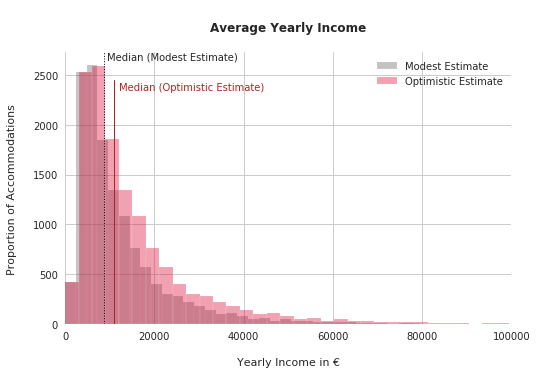

In [31]:
sns.set_style("whitegrid")
plt.figure(figsize=(8,5))

sns.distplot(df['modest_income'], kde=False, bins=100, color='dimgrey')
sns.distplot(df['optimistic_income'], kde=False, bins=100, color='crimson')

plt.title('\nAverage Yearly Income\n', fontweight='bold')
plt.legend(['Modest Estimate', 'Optimistic Estimate'])
plt.xlabel('\nYearly Income in €')
plt.xlim((0,100000))
plt.ylabel('Proportion of Accommodations\n')

# draw and label a line with median value of modest estimate
plt.axvline(x=8709, ymin=0, ymax=1, linewidth=1, linestyle=':', color='black')
plt.text(9350, 2650, 'Median (Modest Estimate)')

# draw and label a line with median value of optimistic estimate
plt.axvline(x=10886, ymin=0, ymax=0.9, linewidth=1, linestyle='-', color='firebrick')
plt.text(12000, 2350, 'Median (Optimistic Estimate)', color='firebrick');

*Back to: <a href='#Table of contents'> Table of contents</a>*
### 3. Exploratory Data Analysis (EDA)
<a id='3. Exploratory Data Analysis (EDA)'></a>

#### 3.1. Getting Started with a Heat Map
<a id='3.1. Getting Started with a Heat Map'></a>

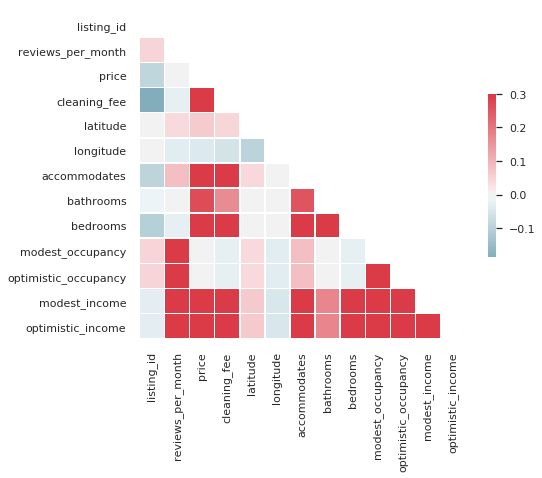

In [32]:
sns.set(style="white")
corr = df.corr()

# generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# set up the matplotlib figure
fig, ax = plt.subplots(figsize=(8, 6))

# generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink":.5});

There is reason to believe that a) the number of people that can be `accomodated` as an indicator for **size or capacity** and b) the `latitude` as a proxy for **location** may help explaining the demand. (The feature `reviews_per_month` is what we used to estimate the occupancy, so no wonder the correlation is highly red.)

I assume there might be also some **seasonality** that strongly influences the demand. Furthermore, I tend to believe that the so-called **super host status** does something for these hosts which probably greet far more guests than standard hosts. The heat map can't show any such relationship, though, as it uses numeric columns only. So let's walk through all of these factors to visually investigate their effect on demand:

*Back to: <a href='#Table of contents'> Table of contents</a>*
#### 3.2. Seasonal Demand
<a id='3.2. Seasonal Demand'></a>

To examine if there's an underlying seasonality, let's split the dataset we loaded at the very beginning by years. We repeat exactly the same steps we conducted when we pulled out the latest full calendar year.

In [33]:
# split the data by date
count_2018 = df_raw[df_raw["date"].isin(pd.date_range('2018-01-01', '2018-10-31'))]
count_2017 = df_raw[df_raw["date"].isin(pd.date_range('2017-01-01', '2017-12-31'))]
count_2016 = df_raw[df_raw["date"].isin(pd.date_range('2016-01-01', '2016-12-31'))]
count_2015 = df_raw[df_raw["date"].isin(pd.date_range('2015-01-01', '2015-12-31'))]

# set the date as index and sort by index
count_2018 = count_2018.set_index('date').sort_index()
count_2017 = count_2017.set_index('date').sort_index()
count_2016 = count_2016.set_index('date').sort_index()
count_2015 = count_2015.set_index('date').sort_index()

# calculate reviews per month                       
count_2018_monthly = count_2018.groupby([pd.TimeGrouper(freq='M'), 'listing_id'])['review_count']\
                                         .agg({'review_count':{'reviews_per_month_18':'count'}})\
                                         .reset_index()
count_2017_monthly = count_2017.groupby([pd.TimeGrouper(freq='M'), 'listing_id'])['review_count']\
                                         .agg({'review_count':{'reviews_per_month_17':'count'}})\
                                         .reset_index()
count_2016_monthly = count_2016.groupby([pd.TimeGrouper(freq='M'), 'listing_id'])['review_count']\
                                         .agg({'review_count':{'reviews_per_month_16':'count'}})\
                                         .reset_index()
count_2015_monthly = count_2015.groupby([pd.TimeGrouper(freq='M'), 'listing_id'])['review_count']\
                                         .agg({'review_count':{'reviews_per_month_15':'count'}})\
                                         .reset_index()

# flatten the multi-index
count_2018_monthly.columns = ['date', 'listing_id', 'reviews_per_month_18']
count_2017_monthly.columns = ['date', 'listing_id', 'reviews_per_month_17']
count_2016_monthly.columns = ['date', 'listing_id', 'reviews_per_month_16']
count_2015_monthly.columns = ['date', 'listing_id', 'reviews_per_month_15']

# set date as index
count_2018_monthly.set_index('date', inplace=True)
count_2017_monthly.set_index('date', inplace=True)
count_2016_monthly.set_index('date', inplace=True)
count_2015_monthly.set_index('date', inplace=True)

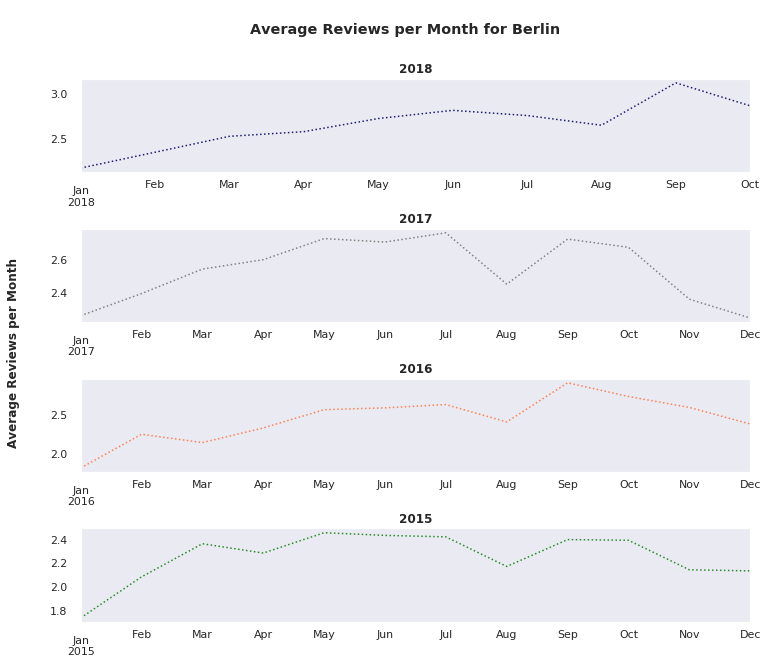

In [34]:
sns.set(style="dark")
fig, axes = plt.subplots(4, 1, figsize=(12,10))

sub_1 = count_2018_monthly.groupby('date')['reviews_per_month_18'].mean()
sub_1.plot(ax=axes[0], color='midnightblue', style=':')
axes[0].set_title('2018', fontweight='bold')
axes[0].set_xlabel('') 

sub_2 = count_2017_monthly.groupby('date')['reviews_per_month_17'].mean()
sub_2.plot(ax=axes[1], color='grey', style=':')
axes[1].set_title('2017', fontweight='bold')
axes[1].set_xlabel('') 

sub_3 = count_2016_monthly.groupby('date')['reviews_per_month_16'].mean()
sub_3.plot(ax=axes[2], color='coral', style=':')
axes[2].set_title('2016', fontweight='bold')
axes[2].set_xlabel('') 

sub_4 = count_2015_monthly.groupby('date')['reviews_per_month_15'].mean()
sub_4.plot(ax=axes[3], color='forestgreen', style=':')
axes[3].set_title('2015', fontweight='bold')
axes[3].set_xlabel('') 

# adjust space between subplots and set a title
plt.subplots_adjust(hspace = 0.6)
plt.suptitle('\nAverage Reviews per Month for Berlin\n', fontweight='bold')

# plot common y-label
fig.text(0.04, 0.5, 'Average Reviews per Month', fontweight='bold', va='center', rotation='vertical');

Be aware that - unlike all other plots - the one for 2018 ranges from January to October only! 

Having said that, the same pattern repeats every year: The peak of visitors is from May to July, and again in September und October. It significantly drops during the winter months and in August. The latter finding is interesting: Tourists seem to avoid city trips in high summer and probably prefer beach holidays.

*Back to: <a href='#Table of contents'> Table of contents</a>*
#### 3.3. Demand by Status SUPERHOST
<a id='3.3. Demand by Status SUPERHOST'></a>

In [35]:
# check super host column for NaN's
df.host_is_superhost.isna().sum()

2

In [36]:
# replace NaN's with value 'false' for not being a superhost
df.host_is_superhost.fillna(value='f', inplace=True)
df.host_is_superhost.isna().sum()

0

*How does the split between super hosts and standard hosts look like?*

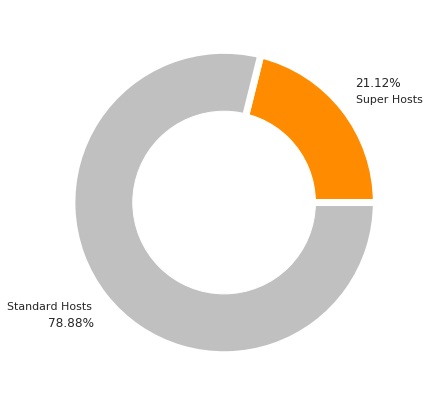

In [37]:
# assign the data
super_host    = df.host_is_superhost.value_counts()['t']
no_super_host = df.host_is_superhost.value_counts()['f']
names = ['Super Hosts','Standard Hosts']
size  = [super_host, no_super_host]

# call a pie chart
plt.pie(size, labels=names, colors=['darkorange','silver'], 
        autopct='%.2f%%', pctdistance=1.28,
        wedgeprops={'linewidth':7, 'edgecolor':'white'})

# create circle for the center of the plot to make the pie look like a donut
my_circle = plt.Circle((0,0), 0.6, color='white')

# plot the donut chart
fig = plt.gcf()
fig.set_size_inches(7,7)
fig.gca().add_artist(my_circle)
plt.show()

In [46]:
# the overall median differences between superhosts and standard hosts
df.groupby('host_is_superhost')['modest_occupancy'].agg(np.median)

host_is_superhost
f    12.6
t    21.0
Name: modest_occupancy, dtype: float64

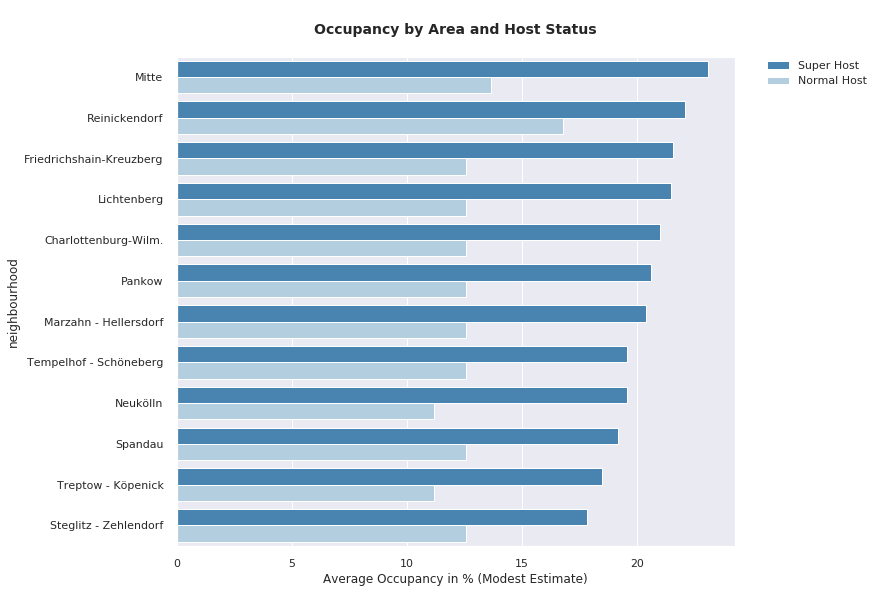

In [47]:
# group by neighbourhood and by status, then take the median occupancy
df_grouped = pd.DataFrame(df.groupby(['neighbourhood', 'host_is_superhost'])['modest_occupancy'].agg(np.median))
df_grouped.sort_values(by='modest_occupancy', ascending=False, inplace=True)
df_grouped.reset_index(inplace=True)

# plot grouped dataframe with seaborn
sns.set_style('darkgrid')
fig, ax = plt.subplots(figsize=(10, 9))
sns.barplot(x='modest_occupancy', y='neighbourhood', hue='host_is_superhost', hue_order=['t', 'f'], 
            data=df_grouped, palette="Blues_r")

# add title and axis label
ax.set_title('\nOccupancy by Area and Host Status\n', fontsize=14, fontweight='bold')
ax.set(xlabel='Average Occupancy in % (Modest Estimate)')

# rename legend labels & put legend outside plot
handles, labels = ax.get_legend_handles_labels()
ax.legend((handles), ('Super Host', 'Normal Host'), bbox_to_anchor=(1.05, 1), borderaxespad=0.);

In [48]:
# the overall median differences between superhosts and standard hosts
df.groupby('host_is_superhost')['modest_income'].agg(np.median)

host_is_superhost
f     7862.4
t    12769.2
Name: modest_income, dtype: float64

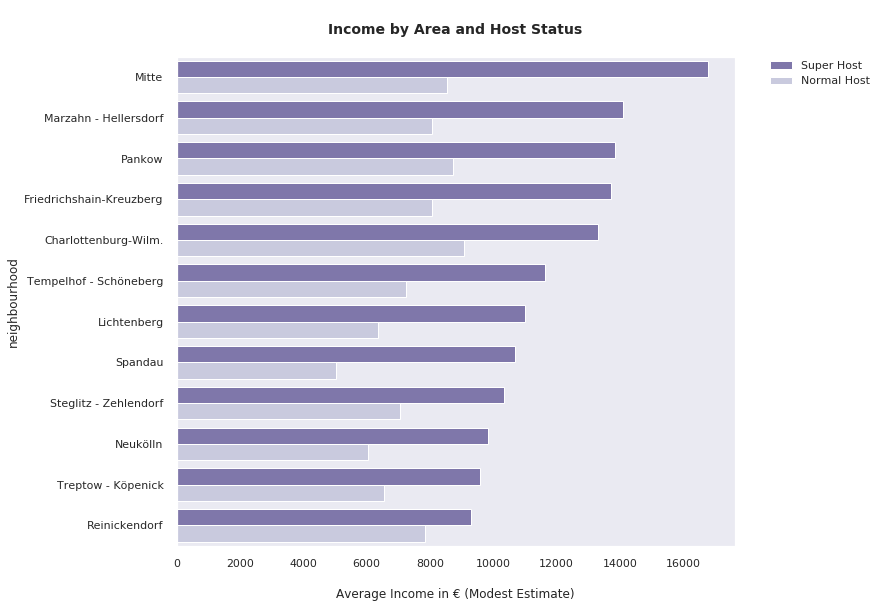

In [44]:
# group by neighbourhood and by status, then take the median income
df_grouped = pd.DataFrame(df.groupby(['neighbourhood', 'host_is_superhost'])['modest_income'].agg(np.median))
df_grouped.sort_values(by='modest_income', ascending=False, inplace=True)
df_grouped.reset_index(inplace=True)

# plot grouped dataframe with seaborn
sns.set_style('dark')
fig, ax = plt.subplots(figsize=(10, 9))
sns.barplot(x='modest_income', y='neighbourhood', hue='host_is_superhost', hue_order=['t', 'f'], 
            data=df_grouped, palette="Purples_r")

# add title and axis label
ax.set_title('\nIncome by Area and Host Status\n', fontsize=14, fontweight='bold')
ax.set(xlabel='\nAverage Income in € (Modest Estimate)')

# rename legend labels & put legend outside plot
handles, labels = ax.get_legend_handles_labels()
ax.legend((handles), ('Super Host', 'Normal Host'), bbox_to_anchor=(1.25, 1), borderaxespad=0.);

It's definitely worth it aspring for becoming a super host! The differences in occupancy and income leap to the eye!

*Back to: <a href='#Table of contents'> Table of contents</a>*
#### 3.4. Demand by Neighbourhood
<a id='3.4. Demand by Neighbourhood'></a>

*Lollipop Charts with two observations*

In [76]:
def lollipop_with_2(dataframe, about, y_col, x1_col, x2_col):
    ''' Function that creates a lollipop chart with 
    two observations (x-values) per group (y-value). '''
       
    # set style
    sns.set_style("dark")
    
    # prepare data
    df_plot = dataframe[[y_col, x1_col, x2_col]].groupby(y_col).apply(lambda x: x.mean())
    df_plot.sort_values(x1_col, inplace=True)
    df_plot.reset_index(inplace=True)
        
    # draw plot
    fig, ax = plt.subplots(figsize=(10,8))
    ax.hlines (y=df_plot.index, xmin=df_plot[x1_col], xmax=df_plot[x2_col], color='grey', alpha=0.7, linewidth=2)
    ax.scatter(y=df_plot.index, x=df_plot[x1_col], s=75, color='skyblue', alpha=0.7, label=x1_col)
    ax.scatter(y=df_plot.index, x=df_plot[x2_col], s=75, color='darkblue', alpha=0.7, label=x2_col)
    ax.legend()
    
    # title, label, ticks and xlim
    ax.set_title('\nAverage ' + about + ' by District\n', fontdict={'size':12, 'weight':'bold'})
    ax.set_xlabel('\n' + about)
    ax.set_yticks(df_plot.index)
    ax.set_yticklabels(df_plot[y_col], rotation=0, 
                       fontdict={'horizontalalignment': 'right', 'size':12})
    
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.show()

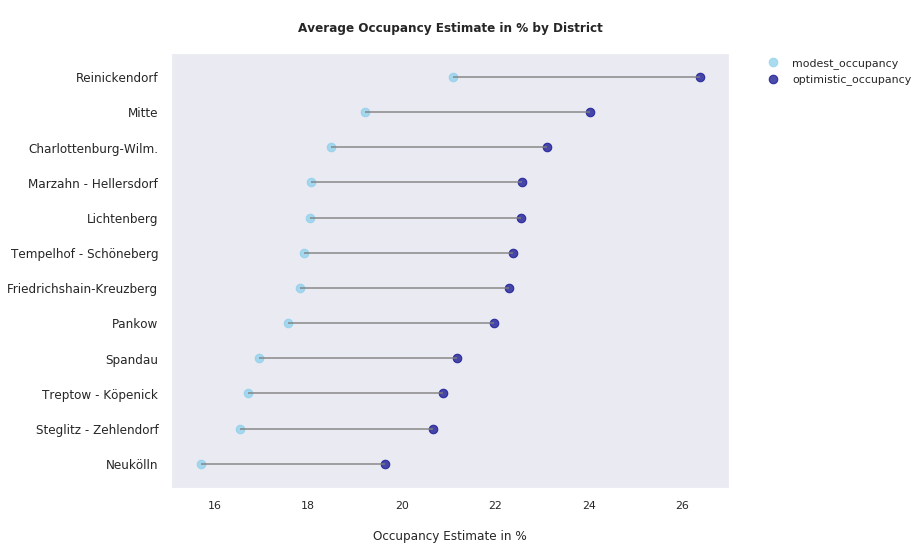

In [77]:
lollipop_with_2(df, 'Occupancy Estimate in %', 'neighbourhood', 'modest_occupancy', 'optimistic_occupancy')

Unsurprisingly, *Mitte* is the most in-demand area: it's a hot spot, right in the centre and close to most place of interest. But why the heck is *Reinickendorf* on top?

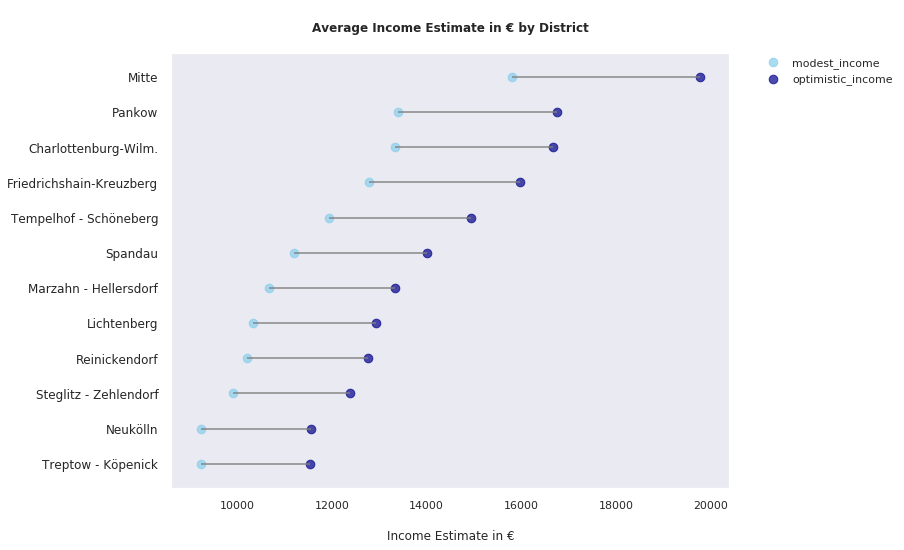

In [78]:
lollipop_with_2(df, 'Income Estimate in €', 'neighbourhood', 'modest_income', 'optimistic_income')

It seems as if *Reinickendorf* benefits from rather low room rates which lead to a high occupancy as we have seen before. When it comes to earnings, Mitte is in the vanguard.

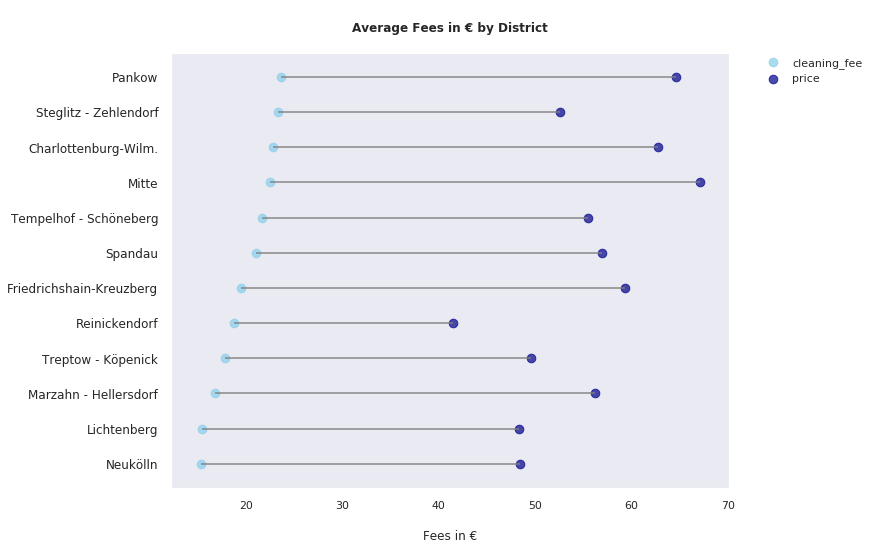

In [79]:
lollipop_with_2(df, 'Fees in €', 'neighbourhood', 'cleaning_fee', 'price')

*Lollipop Charts with one observation and one group highlighted*

In [49]:
def lollipop_with_highlight(dataframe, about, y_col, y_highlight, x_col):
    ''' Function that creates a lollipop chart with only one observation (x-value) 
    per group (y-value) and the option to highlight one of the grouped values. '''
    
    # set style
    sns.set_style("dark")
    
    # prepare data
    df_plot = dataframe[[y_col, x_col]].groupby(y_col).apply(lambda x: x.mean())
    df_plot.sort_values(x_col, inplace=True)
    df_plot.reset_index(inplace=True)

    # highlight district specified as y_highlight
    my_color = np.where(df_plot[y_col] == y_highlight, 'crimson', 'skyblue')
    my_size  = np.where(df_plot[y_col] == y_highlight, 70, 30)

    # draw plot
    fig, ax = plt.subplots(figsize=(8,8))
    ax.hlines (y=df_plot.index, xmin=0, xmax=df_plot[x_col], color=my_color, alpha=0.5, linewidth=2)
    ax.scatter(y=df_plot.index, x=df_plot[x_col], s=my_size, color=my_color, alpha=1, label=x_col)
    ax.legend()

    # title, label, ticks and xlim
    ax.set_title('\nAverage ' + about + ' by District\n', fontdict={'size':12, 'weight':'bold'})
    ax.set_xlabel('\n' + about)
    ax.set_yticks(df_plot.index)
    ax.set_yticklabels(df_plot[y_col], rotation=0, 
                       fontdict={'horizontalalignment': 'right', 'size':12})
    
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.show()

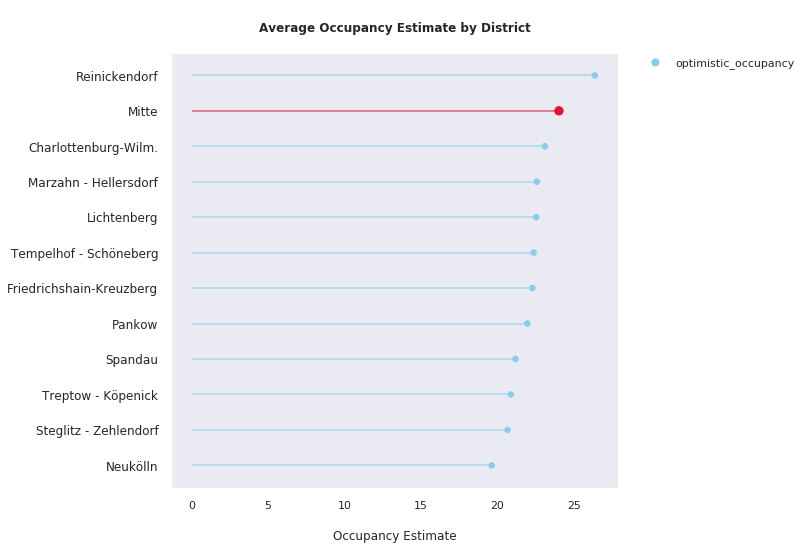

In [51]:
lollipop_with_highlight(df, 'Occupancy Estimate', 'neighbourhood', 'Mitte', 'optimistic_occupancy')

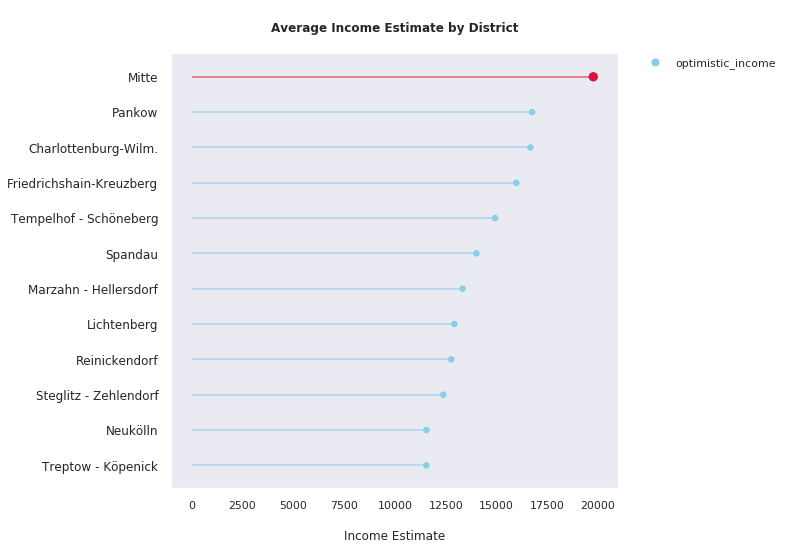

In [52]:
lollipop_with_highlight(df, 'Income Estimate', 'neighbourhood', 'Mitte', 'optimistic_income')

*Back to: <a href='#Table of contents'> Table of contents</a>*
#### 3.5. Demand by Capacity
<a id='3.5. Demand by Capacity'></a>

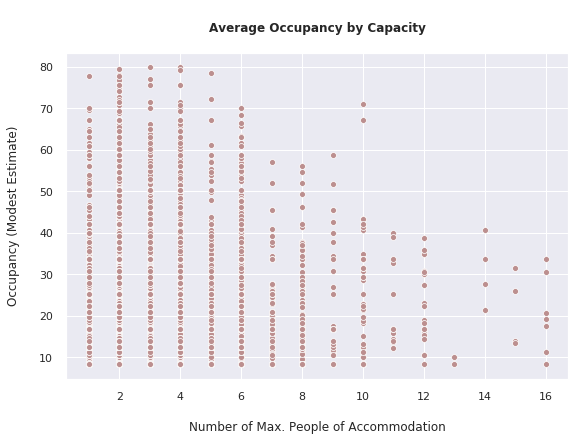

In [57]:
sns.set_style("darkgrid")
fig, ax = plt.subplots(figsize=(9,6))

sns.scatterplot(x="accommodates", y="modest_occupancy", color='rosybrown',  data=df)

plt.title('\nAverage Occupancy by Capacity\n', fontsize=12, fontweight='bold')
plt.xlabel('\nNumber of Max. People of Accommodation')
plt.ylabel('Occupancy (Modest Estimate)\n');

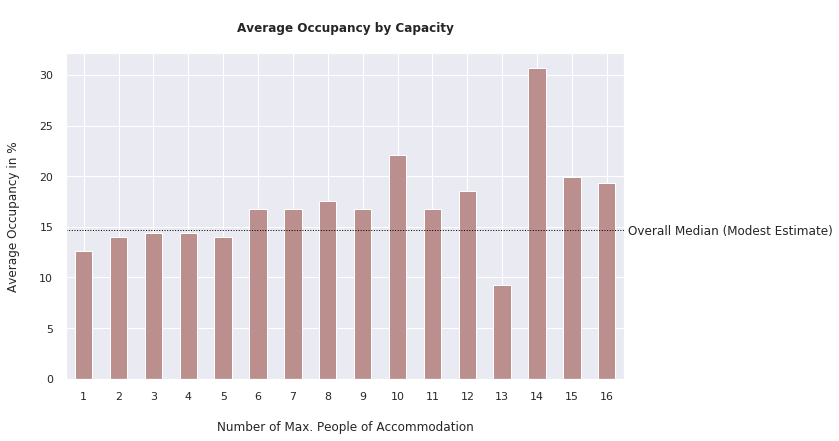

In [58]:
# group by accomodates and plot median occupancy
df.groupby('accommodates')['modest_occupancy']\
                          .median()\
                          .plot(kind='bar', figsize=(10,6), color='rosybrown')

# beautify the plot
plt.xlabel('\nNumber of Max. People of Accommodation', fontsize=12)
plt.xticks(rotation='horizontal')
plt.ylabel('Average Occupancy in %\n', fontsize=12)
plt.title('\nAverage Occupancy by Capacity\n', fontsize=12, fontweight='bold')

# draw and label the median value
plt.axhline(y=14.7, xmin=0, xmax=1, linewidth=1, linestyle=':', color='black')
plt.text(x=15.6, y=14.2, s='Overall Median (Modest Estimate)');

Generally, bigger homes seem to be sold more often than smaller ones. Perhaps this is apparent from the fact, that groups save comparatively more moeny utilizing Airbnb than a couple for example. It follows that accommodations with a bigger capacity enjoy greater popularity.

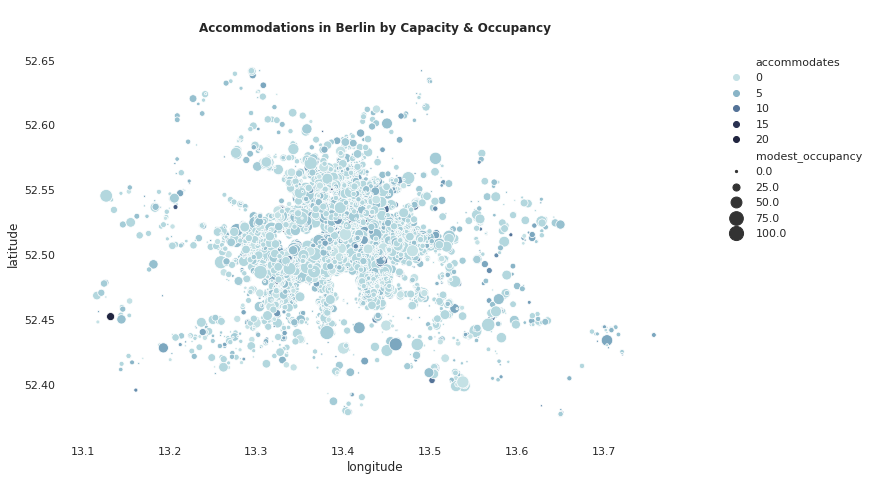

In [59]:
# prepare plot
sns.set_style("white")
cmap = sns.cubehelix_palette(rot=-.2, as_cmap=True)
fig, ax = plt.subplots(figsize=(11,7))

# draw scatter plot
ax = sns.scatterplot(x="longitude", y="latitude", size='modest_occupancy', sizes=(5, 200),
                     hue='accommodates', palette=cmap,  data=df)
ax.legend(bbox_to_anchor=(1.3, 1), borderaxespad=0.)
plt.title('\nAccommodations in Berlin by Capacity & Occupancy\n', fontsize=12, fontweight='bold')

# remove spines
sns.despine(ax=ax, top=True, right=True, left=True, bottom=True);

*Back to: <a href='#Table of contents'> Table of contents</a>*
### 4. Interpreting the Data
<a id='4. Interpreting the Data'></a>

**> Seasonality**

High season for lodgings in Berlin is during late spring, early summer, specifically from May to July, and during the autumn months September and October. You may use your apartment yourself during the rest of year and offer it in these periods to get the most out of it.

**> Super Host**

To be a superhost is a cash machine. Yes, I'm overstating, but you get the point. The occupancy rate in superhosts' lodgings is almost twice as high as in standard hosts' lodgings, and the income 60% higher.

**> Location, Location, Location**

If you don't want to live in the vibrant, loud centre of Berlin yourselves - well, that's bad luck for you! Because tourists want to rent airbnb accommodations right here, particularly in *Mitte* or *Charlottenburg*, and are willing to pay more for them than for lodgings in outlying districts.

**> Capacity**

Travelers in (bigger) groups benefit much more from paying less by using Airbnb than couples or small groupy. That implies, that lodgings accommodating 6 people onwards tend to be stronger in-demand than smaller ones.

Here comes the ideal **recipe** for selling your apartment as often and as expensive as possible:
- Rent a big lodging in Mitte or Charlottenburg 
- that accommodates at least 6 people, 
- offer it from May to July and again in September as well as in October 
- and try to do everything to be awarded a superhost.

😉 

*Back to: <a href='#Table of contents'> Table of contents</a>*
### 5. Appendix 
<a id='5. Appendix'></a>

All resources used in this notebook are listed below.

Data
- Inside Airbnb: http://insideairbnb.com/get-the-data.html

Occupancy Model
- http://insideairbnb.com/about.html
- https://www.airbnbcitizen.com/hosts-on-airbnb-have-welcomed-700000-guests-to-berlin-in-2017/
- https://www.airbnbcitizen.com/wp-content/uploads/2016/04/airbnb-community-berlin-en.pdf

Lollipop Plots
- https://python-graph-gallery.com/184-lollipop-plot-with-2-groups/
- https://python-graph-gallery.com/183-highlight-a-group-in-lollipop/
- https://www.machinelearningplus.com/plots/top-50-matplotlib-visualizations-the-master-plots-python/#16.-Lollipop-Chart

Bubble Plots
- https://glowingpython.blogspot.com/2011/11/how-to-make-bubble-charts-with.html
- https://seaborn.pydata.org/examples/scatterplot_sizes.html

Inspiration
- https://towardsdatascience.com/airbnb-rental-listings-dataset-mining-f972ed08ddec
- https://towardsdatascience.com/improving-airbnb-yield-prediction-with-text-mining-9472c0181731
- https://www.kaggle.com/yogi045/how-to-become-top-earner-in-airbnb?utm_medium=email&utm_source=intercom&utm_campaign=datanotes-2019